In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
import os

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import parallel_where_binary, Aligner4
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

from joblib import Parallel, delayed
import time

Setting environment for Gordon


In [2]:
from registration_utilities import affine_components_to_vector

In [4]:
stack_fixed = 'MD590'

In [5]:
train_sample_scheme = 1
global_transform_scheme = 1

stack_moving = 'atlas_on_MD589'

In [6]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [7]:
label_to_name_fixed = {i+1: name for i, name in enumerate(sorted(structures))}
name_to_label_fixed = {n:l for l, n in label_to_name_fixed.iteritems()}

In [8]:
label_to_name_moving = {i+1: name for i, name in enumerate(sorted(structures))}
name_to_label_moving = {n:l for l, n in label_to_name_moving.iteritems()}

In [9]:
labelIndexMap_m2f = {}
for label_m, name_m in label_to_name_moving.iteritems():
    labelIndexMap_m2f[label_m] = name_to_label_fixed[name_m]

In [10]:
# volume_fixed = {name_to_label_fixed[name]: bp.unpack_ndarray_file(os.path.join(VOLUME_ROOTDIR, '%(stack)s/score_volumes/%(stack)s_down32_scoreVolume_%(name)s_trainSampleScheme_%(scheme)d.bp' % \
#                                                     {'stack': stack_fixed, 'name': name, 'scheme':train_sample_scheme}))
#                for name in structures}

volume_fixed = {name_to_label_fixed[name]: DataManager.load_score_volume(stack=stack_fixed, label=name, downscale=32, train_sample_scheme=train_sample_scheme)
               for name in structures}


print volume_fixed.values()[0].shape

vol_fixed_xmin, vol_fixed_ymin, vol_fixed_zmin = (0,0,0)
vol_fixed_ymax, vol_fixed_xmax, vol_fixed_zmax = volume_fixed.values()[0].shape

(408, 548, 358)


In [43]:
# volume_moving = {name_to_label_moving[name]: bp.unpack_ndarray_file(os.path.join(VOLUME_ROOTDIR, '%(stack)s/score_volumes/%(stack)s_down32_scoreVolume_%(name)s.bp' % \
#                                                     {'stack': stack_moving, 'name': name}))
#                for name in structures}

volume_moving = {name_to_label_moving[name]: DataManager.load_score_volume(stack=stack_moving, label=name, downscale=32, train_sample_scheme=None)
               for name in structures}

print volume_moving.values()[0].shape

vol_moving_xmin, vol_moving_ymin, vol_moving_zmin = (0,0,0)
vol_moving_ymax, vol_moving_xmax, vol_moving_zmax = volume_moving.values()[0].shape

(348, 421, 377)


In [44]:
# aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f={14:14})

In [45]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=labelIndexMap_m2f)

In [46]:
aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
# aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[name_to_label_moving['SNR_R']])

In [47]:
gradient_filepath_map_f = {ind_f: VOLUME_ROOTDIR + '/%(stack)s/score_volume_gradients/%(stack)s_down32_scoreVolume_%(label)s_trainSampleScheme_%(scheme)d_%%(suffix)s.bp' % \
                           {'stack': stack_fixed, 'label': label_to_name_fixed[ind_f], 'scheme':train_sample_scheme}
                           for ind_m, ind_f in labelIndexMap_m2f.iteritems()}

In [48]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f, indices_f=None)

set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])


load gradient 1: 3.426160 seconds
load gradient 2: 3.369840 seconds
load gradient 3: 3.867440 seconds
load gradient 4: 3.570814 seconds
load gradient 5: 3.297323 seconds
load gradient 6: 3.358847 seconds
load gradient 7: 3.740425 seconds
load gradient 8: 3.489540 seconds
load gradient 9: 3.843945 seconds
load gradient 10: 3.853719 seconds
load gradient 11: 4.065766 seconds
load gradient 12: 3.698739 seconds
load gradient 13: 3.416651 seconds
load gradient 14: 3.426225 seconds
load gradient 15: 3.793881 seconds
load gradient 16: 4.145486 seconds
load gradient 17: 3.855243 seconds
load gradient 18: 3.765907 seconds
load gradient 19: 3.418707 seconds
load gradient 20: 3.948667 seconds
load gradient 21: 3.352134 seconds
load gradient 22: 3.598420 seconds
load gradient 23: 4.242528 seconds
load gradient 24: 4.071121 seconds
load gradient 25: 3.386625 seconds
load gradient 26: 3.624042 seconds
load gradient 27: 3.861174 seconds
load gradient 28: 4.075637 seconds
overall: 103.568797 seconds


In [52]:
global_transform_scheme = 1

In [53]:
# largely the same optimization path regardless of the starting condition

# For rigid, 
# grad_computation_sample_number = 1e5 is desired
# grid_search_iteration_number and grid_search_sample_number seem to be unimportant as well, set to 100
# lr1=10, lr2=.1 is best

# For affine, 
# lr2 = .001 is too slow; 0.1 rises faster than 0.01
# lr1 does not matter
# plateus around iteration 100, but keep rising afterwards.
# grad_computation_sample_number does not make a difference

if global_transform_scheme == 1:

    T, scores = aligner.optimize(type='affine', max_iter_num=1000, history_len=50, terminate_thresh=1e-4,
    #                              indices_m=[name_to_label_fixed['SNR_L']],
                                 indices_m=None,
                                grid_search_iteration_number=30,
                                 grid_search_sample_number=100,
                                 grad_computation_sample_number=1e5,
                                 lr1=10, lr2=0.1)
    
elif global_transform_scheme == 2:
    
    T, scores = aligner.optimize(type='rigid', max_iter_num=1000, history_len=50, terminate_thresh=1e-4,
#                                  indices_m=[name_to_label_moving['Tz'], name_to_label_moving['12N'], name_to_label_moving['Pn']],
                                 indices_m=None,
                                grid_search_iteration_number=30,
                                 grid_search_sample_number=100,
                                 grad_computation_sample_number=1e5,
                                 lr1=10, lr2=0.1)

No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 18
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
grid search: 5.118873 seconds
0.000000 0.107611
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 20
grid search: 3.596478 seconds
0.107611 0.132491
No valid voxels after transform: ind_m = 16
grid search: 2.912346 seconds
grid search: 2.315185 seconds
0.132491 0.136813
grid search: 1.693374 seconds
0.13

params_best_upToNow [-60.0830458  -62.42887235  19.06962125  -0.41372606]


score: 0.141774
iteration 1
score: 0.127950
iteration 2
score: 0.154729
iteration 3
score: 0.154905
iteration 4
score: 0.155396
iteration 5
score: 0.174444
iteration 6
score: 0.177319
iteration 7
score: 0.171572
iteration 8
score: 0.174035
iteration 9
score: 0.173259
iteration 10
score: 0.175700
iteration 11
score: 0.176457
iteration 12
score: 0.176743
iteration 13
score: 0.175182
iteration 14
score: 0.179198
iteration 15
score: 0.181051
iteration 16
score: 0.180674
iteration 17
score: 0.180492
iteration 18
score: 0.181080
iteration 19
score: 0.182204
iteration 20
score: 0.181188
iteration 21
score: 0.182512
iteration 22
score: 0.184754
iteration 23
score: 0.184843
iteration 24
score: 0.184766
iteration 25
score: 0.184832
iteration 26
score: 0.181289
iteration 27
score: 0.185823
iteration 28
score: 0.186429
iteration 29
score: 0.186509
iteration 30
score: 0.190389
iteration 31
score: 0.192837
iteration 32
score: 0.194818
iteration 33
score: 0.198370
iteration 34
score: 0.200567
iterati

[[  9.81022509e-01   1.69298802e-01   9.45132370e-02  -1.18572622e+02]
 [ -1.59345324e-01   9.81677784e-01  -1.04488262e-01  -9.62810145e+00]
 [ -1.10471283e-01   8.74450946e-02   9.90024975e-01   4.28078665e+01]]
0.148124 0.140923


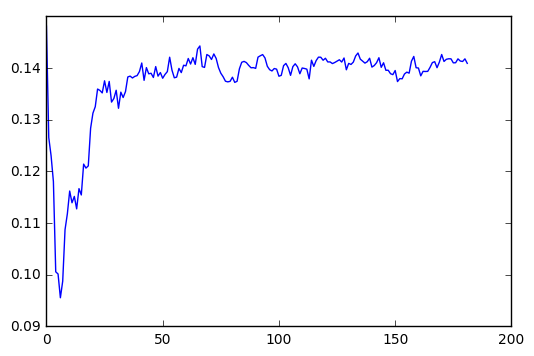

In [56]:
print T.reshape((3,4))
plt.plot(scores);
print max(scores), scores[-1]

In [49]:
# Consistency analysis

trial_num = 10
trial_results = []

for _ in range(trial_num):

    if global_transform_scheme == 1:

        T, scores = aligner.optimize(type='affine', max_iter_num=1000, history_len=50, terminate_thresh=1e-4,
                                     indices_m=None,
                                    grid_search_iteration_number=30,
                                     grid_search_sample_number=100,
                                     grad_computation_sample_number=1e5,
                                     lr1=10, lr2=0.1)

    elif global_transform_scheme == 2:

        T, scores = aligner.optimize(type='rigid', max_iter_num=1000, history_len=10, terminate_thresh=1e-4,
                                     indices_m=None,
                                    grid_search_iteration_number=30,
                                     grid_search_sample_number=100,
                                     grad_computation_sample_number=1e5,
                                     lr1=10, lr2=0.1)


    print T.reshape((3,4))
#     plt.plot(scores);
#     plt.show();
    print max(scores), scores[-1]
    
    trial_results.append((scores, T))

No valid voxels after transform: ind_m = 14
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
grid search: 5.091353 seconds
0.000000 0.102763
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 17
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 16
No valid voxels after transf

params_best_upToNow [-65.05403161 -87.75936245   4.48795616  -0.55007465]


score: 0.134610
iteration 1
score: 0.104455
iteration 2
score: 0.085251
iteration 3
score: 0.118511
iteration 4
score: 0.111130
iteration 5
score: 0.129597
iteration 6
score: 0.127437
iteration 7
score: 0.124510
iteration 8
score: 0.118867
iteration 9
score: 0.128776
iteration 10
score: 0.128006
iteration 11
score: 0.125135
iteration 12
score: 0.115281
iteration 13
score: 0.119102
iteration 14
score: 0.121601
iteration 15
score: 0.123840
iteration 16
score: 0.121591
iteration 17
score: 0.119603
iteration 18
score: 0.120542
iteration 19
score: 0.122341
iteration 20
score: 0.121777
iteration 21
score: 0.121684
iteration 22
score: 0.121597
iteration 23
score: 0.120828
iteration 24
score: 0.119334
iteration 25
score: 0.119907
iteration 26
score: 0.121855
iteration 27
score: 0.122240
iteration 28
score: 0.120707
iteration 29
score: 0.122409
iteration 30
score: 0.121494
iteration 31
score: 0.121176
iteration 32
score: 0.121584
iteration 33
score: 0.121314
iteration 34
score: 0.119768
iterati

[[  7.94575060e-01   5.98107580e-01   1.04488262e-01  -9.37774790e+01]
 [ -6.06611144e-01   7.89360607e-01   9.45132370e-02  -2.04178977e+01]
 [ -2.59498345e-02  -1.38481605e-01   9.90024975e-01   7.32016828e+00]]
0.13461 0.122313


score: 0.122313
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 3
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
grid search: 5.403786 seconds
0.000000 0.123845
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
grid search: 3.708876 seconds
0.123845 0.125113
grid search: 2.995150 seconds
0.125113 0.136152
grid search: 2.309673 seconds
0.136152 0.140558
grid search: 1.794533 seconds
grid search: 1.498813 seconds
grid search: 1.089924 seconds
0.140558 0.143455
grid search: 1.002883 seconds
grid search: 0.789182 seconds
0.143455 0.146427
grid search: 0.792799 seconds
0.146427 0.147689
grid search: 0.696063 seconds
0

params_best_upToNow [ -1.08593437e+02  -1.83993763e+01   3.62991777e+01  -9.36759947e-02]


score: 0.148125
iteration 1
score: 0.115160
iteration 2
score: 0.112864
iteration 3
score: 0.089040
iteration 4
score: 0.085875
iteration 5
score: 0.083560
iteration 6
score: 0.082415
iteration 7
score: 0.078861
iteration 8
score: 0.078380
iteration 9
score: 0.077477
iteration 10
score: 0.083561
iteration 11
score: 0.075749
iteration 12
score: 0.075155
iteration 13
score: 0.074582
iteration 14
score: 0.078837
iteration 15
score: 0.078799
iteration 16
score: 0.080457
iteration 17
score: 0.079111
iteration 18
score: 0.079737
iteration 19
score: 0.075378
iteration 20
score: 0.069843
iteration 21
score: 0.074622
iteration 22
score: 0.079140
iteration 23
score: 0.080002
iteration 24
score: 0.078068
iteration 25
score: 0.072983
iteration 26
score: 0.068451
iteration 27
score: 0.065715
iteration 28
score: 0.065044
iteration 29
score: 0.065530
iteration 30
score: 0.066780
iteration 31
score: 0.065579
iteration 32
score: 0.066197
iteration 33
score: 0.065367
iteration 34
score: 0.065718
iterati

[[  9.95458054e-01  -1.14241486e-02  -9.45132370e-02  -1.21254201e+02]
 [  1.49285795e-03   9.94524999e-01  -1.04488262e-01  -3.32178114e+01]
 [  9.51894664e-02   1.03872587e-01   9.90024975e-01   3.26581645e+01]]
0.148125 0.087699


score: 0.087699
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 10
grid search: 5.115243 seconds
0.000000 0.122851
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 17
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid vox

params_best_upToNow [ -1.05560865e+02  -1.87943183e+01   4.53083647e+01  -9.49418719e-02]


score: 0.146854
iteration 1
score: 0.133619
iteration 2
score: 0.121776
iteration 3
score: 0.120735
iteration 4
score: 0.112339
iteration 5
score: 0.099509
iteration 6
score: 0.093461
iteration 7
score: 0.079142
iteration 8
score: 0.073901
iteration 9
score: 0.074827
iteration 10
score: 0.070851
iteration 11
score: 0.071322
iteration 12
score: 0.069582
iteration 13
score: 0.069983
iteration 14
score: 0.071301
iteration 15
score: 0.072316
iteration 16
score: 0.075309
iteration 17
score: 0.073834
iteration 18
score: 0.069150
iteration 19
score: 0.072883
iteration 20
score: 0.073984
iteration 21
score: 0.074540
iteration 22
score: 0.075097
iteration 23
score: 0.076141
iteration 24
score: 0.075907
iteration 25
score: 0.077175
iteration 26
score: 0.077788
iteration 27
score: 0.077163
iteration 28
score: 0.077099
iteration 29
score: 0.076491
iteration 30
score: 0.076367
iteration 31
score: 0.077628
iteration 32
score: 0.077230
iteration 33
score: 0.077549
iteration 34
score: 0.074015
iterati

[[  9.94526092e-01  -2.33910577e-04  -1.04488262e-01  -1.19646264e+02]
 [  1.01640121e-02   9.95471718e-01   9.45132370e-02  -6.53067994e+00]
 [  1.03993002e-01  -9.50579002e-02   9.90024975e-01   2.47011507e+01]]
0.146854 0.075681


score: 0.075681
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 7
No valid voxels after transform: ind_m = 10
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 19
No valid voxels after transform: ind_m = 25
No valid voxels a

params_best_upToNow [ -1.08696177e+02  -1.66819602e+01   3.56335517e+01  -9.27371448e-02]


score: 0.147851
iteration 1
score: 0.116832
iteration 2
score: 0.095763
iteration 3
score: 0.080487
iteration 4
score: 0.073345
iteration 5
score: 0.072923
iteration 6
score: 0.068357
iteration 7
score: 0.066775
iteration 8
score: 0.066399
iteration 9
score: 0.069406
iteration 10
score: 0.068523
iteration 11
score: 0.067509
iteration 12
score: 0.069946
iteration 13
score: 0.068505
iteration 14
score: 0.064381
iteration 15
score: 0.066911
iteration 16
score: 0.066490
iteration 17
score: 0.064864
iteration 18
score: 0.064072
iteration 19
score: 0.065348
iteration 20
score: 0.065691
iteration 21
score: 0.065354
iteration 22
score: 0.067210
iteration 23
score: 0.069185
iteration 24
score: 0.071733
iteration 25
score: 0.074012
iteration 26
score: 0.075710
iteration 27
score: 0.078638
iteration 28
score: 0.079231
iteration 29
score: 0.079019
iteration 30
score: 0.080371
iteration 31
score: 0.079183
iteration 32
score: 0.079401
iteration 33
score: 0.077751
iteration 34
score: 0.076403
iterati

[[  9.95446890e-01  -1.23587291e-02  -9.45132370e-02  -1.21296379e+02]
 [  2.42656687e-03   9.94523160e-01  -1.04488262e-01  -3.15418613e+01]
 [  9.52869452e-02   1.03783173e-01   9.90024975e-01   3.21586869e+01]]
0.147851 0.076873


score: 0.076873
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 1
No valid voxels after transform: ind_m = 2
No valid voxels after transform: ind_m = 9
No valid voxels after transform: ind_m = 10
No valid voxels after transform: ind_m = 14
No valid voxels after transform: ind_m = 10
No valid voxels after transform: ind_m = 14
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
grid search: 5.511833 seconds
0.000000 0.111538
No valid voxels after transform: ind_m = 19
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
grid search: 3.

params_best_upToNow [-62.66353711 -60.45370173  19.47386371  -0.39641566]


score: 0.142457
iteration 1
score: 0.133680
iteration 2
score: 0.111793
iteration 3
score: 0.095372
iteration 4
score: 0.093026
iteration 5
score: 0.093340
iteration 6
score: 0.092732
iteration 7
score: 0.095993
iteration 8
score: 0.096269
iteration 9
score: 0.098219
iteration 10
score: 0.096121
iteration 11
score: 0.101035
iteration 12
score: 0.110346
iteration 13
score: 0.116398
iteration 14
score: 0.115565
iteration 15
score: 0.114938
iteration 16
score: 0.116256
iteration 17
score: 0.120848
iteration 18
score: 0.117699
iteration 19
score: 0.118028
iteration 20
score: 0.118069
iteration 21
score: 0.117216
iteration 22
score: 0.119027
iteration 23
score: 0.119506
iteration 24
score: 0.119494
iteration 25
score: 0.120422
iteration 26
score: 0.120117
iteration 27
score: 0.116882
iteration 28
score: 0.120959
iteration 29
score: 0.118967
iteration 30
score: 0.117879
iteration 31
score: 0.119687
iteration 32
score: 0.120796
iteration 33
score: 0.119853
iteration 34
score: 0.119072
iterati

[[  9.53593840e-01   2.85877661e-01   9.45132370e-02  -6.62281738e+01]
 [ -2.95079131e-01   9.49742338e-01   1.04488262e-01  -2.69565145e+01]
 [ -5.98923628e-02  -1.27528247e-01   9.90024975e-01   1.97780142e+01]]
0.142457 0.119571


score: 0.119571
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
grid search: 5.112517 seconds
0.000000 0.113425
No valid voxels after transform: ind_m = 12
No valid voxels after transform: ind_m = 19
No valid voxels after transform: ind_m = 16
grid search: 3.493528 seconds
0.113425 0.142495
grid search: 2.912605 seconds
grid search: 2.296187 seconds
grid search: 1.907217 seconds
grid search: 1.387984 seconds
grid search: 1.106894 seconds
0.142495 0.142600
grid search: 0.987029 seconds
grid search: 0.793392 seconds
grid search: 0.687911 seconds
grid search: 0.708223 seconds
0.142600 0.143851
grid search: 0.685533 seconds
grid search: 0.684748 seconds
0.143851 0.143978
grid search: 0.698966 seconds
grid search: 0.682810 seconds
grid search: 0.697616 seconds
grid search: 0.684766 seconds
grid search: 0.685304 seconds
gr

params_best_upToNow [-67.19874234 -62.62267672  32.58022249  -0.37180472]


score: 0.143978
iteration 1
score: 0.120349
iteration 2
score: 0.128107
iteration 3
score: 0.128033
iteration 4
score: 0.108633
iteration 5
score: 0.112807
iteration 6
score: 0.135676
iteration 7
score: 0.142130
iteration 8
score: 0.130894
iteration 9
score: 0.143089
iteration 10
score: 0.140695
iteration 11
score: 0.138559
iteration 12
score: 0.145208
iteration 13
score: 0.135901
iteration 14
score: 0.136319
iteration 15
score: 0.134763
iteration 16
score: 0.128249
iteration 17
score: 0.128849
iteration 18
score: 0.129993
iteration 19
score: 0.127104
iteration 20
score: 0.125488
iteration 21
score: 0.123163
iteration 22
score: 0.122378
iteration 23
score: 0.120703
iteration 24
score: 0.118824
iteration 25
score: 0.119379
iteration 26
score: 0.113387
iteration 27
score: 0.117639
iteration 28
score: 0.122352
iteration 29
score: 0.115772
iteration 30
score: 0.123045
iteration 31
score: 0.119407
iteration 32
score: 0.121661
iteration 33
score: 0.120821
iteration 34
score: 0.117191
iterati

[[  9.36267592e-01   3.36663624e-01   1.00302550e-01  -5.71053812e+01]
 [ -3.50287154e-01   9.16269607e-01   1.94290808e-01  -9.93878905e+00]
 [ -2.64935301e-02  -2.17042881e-01   9.75802480e-01   1.98721950e+01]]
0.145208 0.12096


score: 0.120960
No valid voxels after transform: ind_m = 14
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
grid search: 5.115568 seconds
0.000000 0.107442
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
grid search: 3.495779 seconds
0.107442 0.126525
grid search: 2.912739 seconds
0.126525 0.131157
grid search: 2.393271 seconds
grid search: 1.808219 seconds
0.131157 0.131571
grid search: 1

params_best_upToNow [-61.44373215 -61.03451413   9.19410982  -0.39938392]


score: 0.138086
iteration 1
score: 0.118816
iteration 2
score: 0.102622
iteration 3
score: 0.104890
iteration 4
score: 0.128939
iteration 5
score: 0.144630
iteration 6
score: 0.142460
iteration 7
score: 0.128631
iteration 8
score: 0.124600
iteration 9
score: 0.133563
iteration 10
score: 0.137240
iteration 11
score: 0.129095
iteration 12
score: 0.122205
iteration 13
score: 0.126016
iteration 14
score: 0.120396
iteration 15
score: 0.128524
iteration 16
score: 0.124029
iteration 17
score: 0.122863
iteration 18
score: 0.116100
iteration 19
score: 0.123395
iteration 20
score: 0.121690
iteration 21
score: 0.123158
iteration 22
score: 0.121525
iteration 23
score: 0.119812
iteration 24
score: 0.122768
iteration 25
score: 0.119204
iteration 26
score: 0.119903
iteration 27
score: 0.119858
iteration 28
score: 0.119221
iteration 29
score: 0.120576
iteration 30
score: 0.119965
iteration 31
score: 0.121029
iteration 32
score: 0.120434
iteration 33
score: 0.119563
iteration 34
score: 0.120923
iterati

[[  9.41900307e-01   3.23299572e-01   9.11109126e-02  -6.11511323e+01]
 [ -3.35038799e-01   9.23610628e-01   1.86258989e-01  -9.71393547e+00]
 [ -2.39335556e-02  -2.05963090e-01   9.78267034e-01   1.50344364e+01]]
0.14463 0.120056


score: 0.120056
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 14
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
grid search: 5.116767 seconds
0.000000 0.117679
No valid voxels after transform: ind_m = 12
No valid voxels after transform: ind_m = 12
No valid voxels after transform: ind_m = 19
No valid voxels after transform: ind_m = 12
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 12
No valid voxels after transform: ind_m = 16
grid search: 3.503655 seconds
0.117679 0.121210
grid sea

params_best_upToNow [-62.37572453 -60.47373906  15.02804605  -0.36861151]


score: 0.140981
iteration 1
score: 0.125955
iteration 2
score: 0.102478
iteration 3
score: 0.093393
iteration 4
score: 0.089159
iteration 5
score: 0.088567
iteration 6
score: 0.086485
iteration 7
score: 0.091019
iteration 8
score: 0.088679
iteration 9
score: 0.088611
iteration 10
score: 0.090275
iteration 11
score: 0.093898
iteration 12
score: 0.102363
iteration 13
score: 0.101582
iteration 14
score: 0.109960
iteration 15
score: 0.114199
iteration 16
score: 0.107934
iteration 17
score: 0.107989
iteration 18
score: 0.114192
iteration 19
score: 0.117148
iteration 20
score: 0.115655
iteration 21
score: 0.118327
iteration 22
score: 0.119727
iteration 23
score: 0.117832
iteration 24
score: 0.118599
iteration 25
score: 0.118888
iteration 26
score: 0.119257
iteration 27
score: 0.117858
iteration 28
score: 0.121047
iteration 29
score: 0.118428
iteration 30
score: 0.113245
iteration 31
score: 0.113853
iteration 32
score: 0.119904
iteration 33
score: 0.117409
iteration 34
score: 0.119850
iterati

[[  9.61172826e-01   2.59256721e-01   9.45132370e-02  -6.52425113e+01]
 [ -2.68561709e-01   9.57578619e-01   1.04488262e-01  -2.96529407e+01]
 [ -6.34145708e-02  -1.25813914e-01   9.90024975e-01   1.54778894e+01]]
0.140981 0.119687


score: 0.119687
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 10
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 14
No valid voxels after transform: ind_m = 25
grid search: 5.123923 seconds
0.000000 0.128328
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 17
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
grid search: 3.495102 seconds
grid search: 3.015700 seco

params_best_upToNow [-66.32063783 -64.39858525  26.28035143  -0.39179365]


score: 0.142299
iteration 1
score: 0.130291
iteration 2
score: 0.137432
iteration 3
score: 0.122147
iteration 4
score: 0.101572
iteration 5
score: 0.104591
iteration 6
score: 0.106258
iteration 7
score: 0.118307
iteration 8
score: 0.114431
iteration 9
score: 0.127643
iteration 10
score: 0.130605
iteration 11
score: 0.143369
iteration 12
score: 0.134500
iteration 13
score: 0.144240
iteration 14
score: 0.145692
iteration 15
score: 0.153408
iteration 16
score: 0.161050
iteration 17
score: 0.168154
iteration 18
score: 0.168600
iteration 19
score: 0.167306
iteration 20
score: 0.163289
iteration 21
score: 0.169971
iteration 22
score: 0.156561
iteration 23
score: 0.159740
iteration 24
score: 0.161382
iteration 25
score: 0.158082
iteration 26
score: 0.157321
iteration 27
score: 0.150111
iteration 28
score: 0.149931
iteration 29
score: 0.147329
iteration 30
score: 0.144320
iteration 31
score: 0.140562
iteration 32
score: 0.143810
iteration 33
score: 0.143607
iteration 34
score: 0.141295
iterati

[[  9.13369858e-01   3.81111307e-01   1.43211989e-01  -6.65055559e+01]
 [ -4.02944808e-01   8.96518355e-01   1.84093242e-01  -1.96538922e+01]
 [ -5.82321607e-02  -2.25851746e-01   9.72419665e-01   1.48476898e+01]]
0.169971 0.119568


score: 0.119568
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 10
No valid voxels after transform: ind_m = 14
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 20
No valid voxels after transform: ind_m = 25
grid search: 5.315871 seconds
0.000000 0.115378
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 16
No valid voxels after transform: ind_m = 25
No valid voxels after transform: ind_m = 19
grid search: 3.701834 seconds
0.115378 0.123570
No valid

params_best_upToNow [ -1.10496870e+02  -9.82770858e+00   4.43849398e+01  -6.02639209e-02]


score: 0.146889
iteration 1
score: 0.122308
iteration 2
score: 0.146065
iteration 3
score: 0.141568
iteration 4
score: 0.138542
iteration 5
score: 0.137749
iteration 6
score: 0.138761
iteration 7
score: 0.138678
iteration 8
score: 0.139369
iteration 9
score: 0.138014
iteration 10
score: 0.138078
iteration 11
score: 0.138787
iteration 12
score: 0.139978
iteration 13
score: 0.137733
iteration 14
score: 0.139517
iteration 15
score: 0.139117
iteration 16
score: 0.140087
iteration 17
score: 0.139056
iteration 18
score: 0.140667
iteration 19
score: 0.142284
iteration 20
score: 0.141232
iteration 21
score: 0.141533
iteration 22
score: 0.143644
iteration 23
score: 0.141126
iteration 24
score: 0.142074
iteration 25
score: 0.144764
iteration 26
score: 0.147045
iteration 27
score: 0.143821
iteration 28
score: 0.144655
iteration 29
score: 0.146064
iteration 30
score: 0.146471
iteration 31
score: 0.145092
iteration 32
score: 0.143893
iteration 33
score: 0.144240
iteration 34
score: 0.142782
iterati

[[  9.99186507e-01   3.60642568e-02  -1.80469878e-02  -1.16963371e+02]
 [ -3.64302364e-02   9.99128389e-01  -2.03789038e-02  -1.16661327e+01]
 [  1.72963078e-02   2.10197817e-02   9.99629435e-01   4.10639492e+01]]
0.147045 0.133225


score: 0.133225


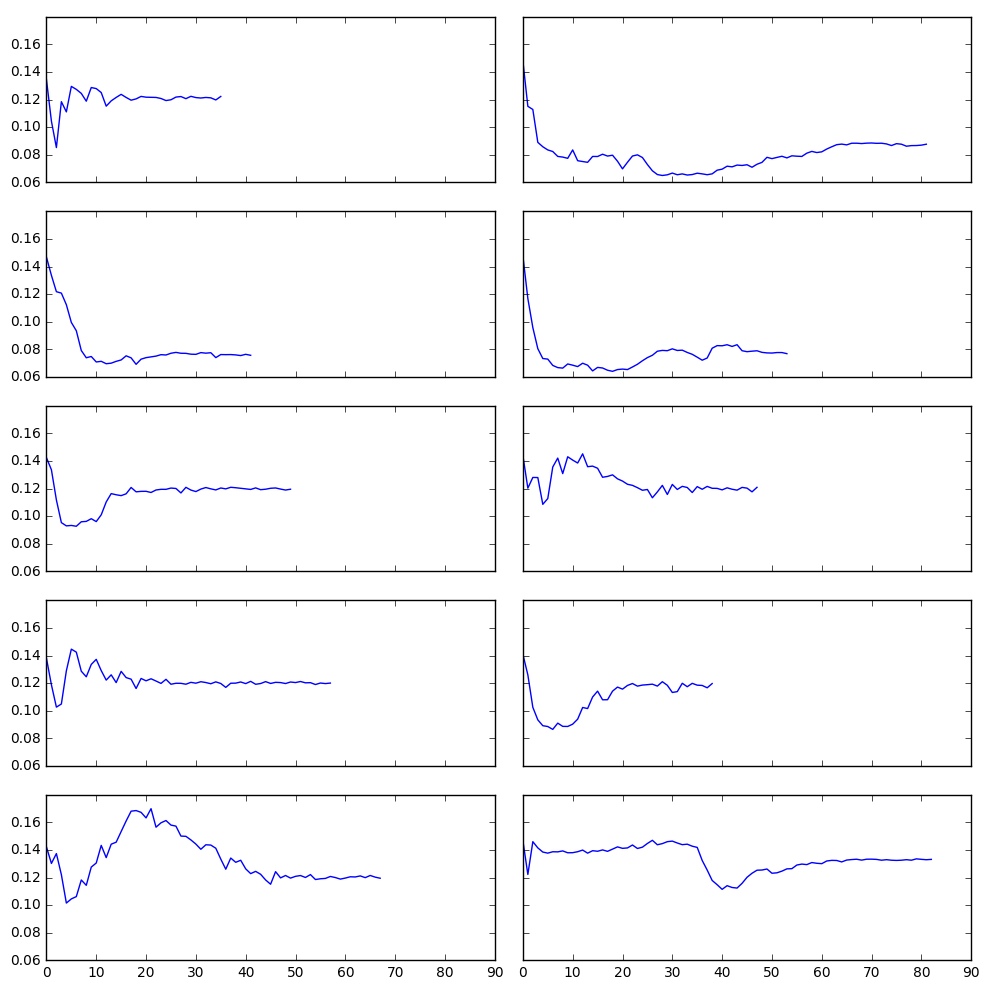

In [51]:
fig, axes = plt.subplots(5, 2, figsize=(10,10), sharey=True, sharex=True)
axes = axes.flatten()
for i, (res, t) in enumerate(trial_results):
    axes[i].plot(res)
plt.tight_layout()
plt.show()

In [18]:
# atlasAlignParams_dir = create_if_not_exists(atlasAlignParams_rootdir + '/%(stack_moving)s_to_%(stack_fixed)s' % \
#                      {'stack_moving': stack_moving, 'stack_fixed': stack_fixed})

In [19]:
params_fp = DataManager.get_global_alignment_parameters_filepath(stack_moving=stack_moving,
                                                                stack_fixed=stack_fixed,
                                                                train_sample_scheme=train_sample_scheme,
                                                                global_transform_scheme=global_transform_scheme)


# with open(atlasAlignParams_dir + '/%(stack_moving)s_down32_scoreVolume_to_%(stack_fixed)s_down32_scoreVolume_trainSampleScheme_%(scheme)d_globalTxScheme_%(gtf_sheme)d_parameters.txt' % \
#           {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'scheme':train_sample_scheme, 'gtf_sheme':global_transform_scheme}, 'w') as f:
with open(params_fp, 'w') as f:
    
    f.write(array_to_one_liner(T))
    f.write(array_to_one_liner(aligner.centroid_m))
    f.write(array_to_one_liner([aligner.xdim_m, aligner.ydim_m, aligner.zdim_m]))
    f.write(array_to_one_liner(aligner.centroid_f))
    f.write(array_to_one_liner([aligner.xdim_f, aligner.ydim_f, aligner.zdim_f]))

In [20]:
score_plot_fp = DataManager.get_global_alignment_score_plot_filepath(stack_moving=stack_moving,
                                                                    stack_fixed=stack_fixed,
                                                                    train_sample_scheme=train_sample_scheme,
                                                                    global_transform_scheme=global_transform_scheme)

fig = plt.figure();
plt.plot(scores);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)

In [59]:
# Try all sets of parameters 

In [60]:
# output_dir = create_if_not_exists(atlasAlignParams_dir + '/rigid_score_plot')

In [61]:
# c = 0

# for lr1 in [.1, 1., 10.]:
#     for lr2 in [1e-1, 1e-2, 1e-3]:
#         for n in [1e3, 1e4, 1e5]:
            
            
#             c += 1
        
#             T, scores = aligner.optimize(type='rigid', max_iter_num=500, history_len=50, terminate_thresh=1e-4,
#             #                              indices_m=[name_to_label_fixed['SNR_L']],
#                                          indices_m=None,
#                                         grid_search_iteration_number=10,
#                                          grid_search_sample_number=100,
#                                          grad_computation_sample_number=n,
#                                          lr1=lr1, lr2=lr2)
#             #                              init_T=[1,0,0,-10,0,1,0,0,0,0,1,0])
            
#             plt.figure();
#             plt.plot(scores);
#             plt.savefig(atlasAlignParams_dir + '/rigid_score_plot/%(stack_moving)s_to_%(stack_fixed)s_scoreEvolution_parameterSet_%(c)d.png' % \
#                         {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'c':c},
#                         bbox_inches='tight')
            
#             with open(atlasAlignParams_dir + '/rigid_score_plot/%(stack_moving)s_to_%(stack_fixed)s_scoreEvolution_parameterSet_%(c)d.txt' % \
#                        {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'c':c}, 'w') as f:
#                 f.write(array_to_one_liner([lr1, lr2, n]))
# #             print max(scores), scores[-1]

In [62]:
# c = 0
# for lr1 in [.1, 1., 10.]:
#     for lr2 in [1e-1, 1e-2, 1e-3]:
#         for n in [1e3, 1e4, 1e5]:
#             c += 1
#             print c, lr1, lr2, int(n)

In [63]:
# READ

In [21]:
# stack_fixed = 'MD591'
stack_moving = 'atlas_on_MD589'

In [22]:
stacks_annotation = ['MD589', 'MD594']
# stack_annotation = 'MD589'

In [23]:
# atlasAlignParams_dir = create_if_not_exists(atlasAlignParams_rootdir + '/%(stack_moving)s_to_%(stack_fixed)s' % \
#                      {'stack_moving': stack_moving, 'stack_fixed': stack_fixed})

In [24]:
# with open(atlasAlignParams_dir + '/%(stack_moving)s_down32_scoreVolume_to_%(stack_fixed)s_down32_scoreVolume_trainSampleScheme_%(scheme)d_parameters.txt' % \
#           {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'scheme':train_sample_scheme}, 'r') as f:
    
params_fp = DataManager.get_global_alignment_parameters_filepath(stack_moving=stack_moving,
                                                                stack_fixed=stack_fixed,
                                                                train_sample_scheme=train_sample_scheme,
                                                                global_transform_scheme=global_transform_scheme)

with open(params_fp, 'r') as f:
    
    lines = f.readlines()
    
    global_params = one_liner_to_arr(lines[0], float)
    centroid_m = one_liner_to_arr(lines[1], float)
    xdim_m, ydim_m, zdim_m  = one_liner_to_arr(lines[2], int)
    centroid_f = one_liner_to_arr(lines[3], float)
    xdim_f, ydim_f, zdim_f  = one_liner_to_arr(lines[4], int)

In [25]:
volumes_annotation = {'MD594':bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_atlasAlignParams_atlas_v2/MD594_to_MD589/MD594_down32_annotationVolume_alignedTo_MD589_down32_annotationVolume.bp'),
                      'MD589': bp.unpack_ndarray_file(VOLUME_ROOTDIR + '/MD589/MD589_down32_annotationVolume.bp')}

In [26]:
# # volume_annotation = bp.unpack_ndarray_file('/home/yuncong/csd395/CSHL_atlasAlignParams_atlas_v2/MD594_to_MD589/MD594_down32_annotationVolume_alignedTo_MD589_down32_annotationVolume.bp')
# volume_annotation = bp.unpack_ndarray_file(VOLUME_ROOTDIR + '/MD589/MD589_down32_annotationVolume.bp')

# print volume_annotation.shape

In [27]:
from registration_utilities import transform_points

In [28]:
annotation_volumes_volume_m_aligned_to_f = {}

for stack, volume_annotation in volumes_annotation.iteritems():
    all_indices_m = set(np.unique(volume_annotation)) - {0}
    nzvoxels_m_temp = {i: parallel_where_binary(volume_annotation==i) for i in all_indices_m}   
    # "_temp" is appended to avoid name conflict with module level variable defined in registration.py
    
    nzs_m_aligned_to_f = {ind_m: transform_points(global_params, pts=nzs_m, 
                                              c=centroid_m, c_prime=centroid_f).astype(np.int16)
                      for ind_m, nzs_m in nzvoxels_m_temp.iteritems()}

    volume_m_aligned_to_f = np.zeros((ydim_f, xdim_f, zdim_f), np.int)

    for ind_m in nzs_m_aligned_to_f.iterkeys():

        xs_f, ys_f, zs_f = nzs_m_aligned_to_f[ind_m].T

        valid = (xs_f >= 0) & (ys_f >= 0) & (zs_f >= 0) & \
        (xs_f < xdim_f) & (ys_f < ydim_f) & (zs_f < zdim_f)

        xs_m, ys_m, zs_m = nzvoxels_m_temp[ind_m].T

        volume_m_aligned_to_f[ys_f[valid], xs_f[valid], zs_f[valid]] = \
        volume_annotation[ys_m[valid], xs_m[valid], zs_m[valid]]

    del nzs_m_aligned_to_f
    
    annotation_volumes_volume_m_aligned_to_f[stack] = volume_m_aligned_to_f

In [29]:
xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f = np.loadtxt('/home/yuncong/csd395/CSHL_volumes2/%(stack_fixed)s/score_volumes/%(stack_fixed)s_down32_scoreVolume_7N_bbox.txt' %\
          dict(stack_fixed=stack_fixed)).astype(np.int)
print xmin_vol_f, xmax_vol_f, ymin_vol_f, ymax_vol_f, zmin_vol_f, zmax_vol_f

0 697 0 383 148 502


In [30]:
from registration_utilities import find_contour_points

In [31]:
downsample_factor = 32
xy_pixel_distance_downsampled = xy_pixel_distance_lossless * downsample_factor
voxel_z_size = section_thickness / xy_pixel_distance_downsampled

In [32]:
# viz_dir = create_if_not_exists(atlasAlignParams_dir + '/%(stack_moving)s_down32_scoreVolume_to_%(stack_fixed)s_down32_scoreVolume_trainSampleScheme_%(scheme)d_global_viz' % \
#           {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'scheme':train_sample_scheme})

viz_dir = create_if_not_exists(DataManager.get_global_alignment_viz_filepath(stack_moving=stack_moving,
                                                        stack_fixed=stack_fixed,
                                                        train_sample_scheme=train_sample_scheme,
                                                        global_transform_scheme=global_transform_scheme))

In [33]:
first_sec, last_sec = metadata_cache['section_limits'][stack_fixed]

In [34]:
stack_colors = {'MD589': (255,0,0), 'MD594': (0,255,0)}

In [35]:
bar = show_progress_bar(first_sec, last_sec)

for sec in range(first_sec, last_sec+1):
    
    if metadata_cache['sections_to_filenames'][stack_fixed][sec] in ['Placeholder', 'Rescan', 'Nonexisting']:
        continue
    
    bar.value = sec

    img_fn = DataManager.get_image_filepath(stack=stack_fixed, section=sec, resol='thumbnail', version='cropped_tif')
    img = imread(img_fn)
    
    viz = img.copy()
    
    z = voxel_z_size * (sec - 1) - zmin_vol_f
    
    # Find fixed volume annotation contours
#     contours_f_on_volume = find_contour_points(volume_fixed[..., int(z)])
#     contours_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] for i, cnts in contours_f_on_volume.iteritems()}

    # Find moving volume annotation contours
    
    for stack, volume_m_aligned_to_f in annotation_volumes_volume_m_aligned_to_f.iteritems():
        contours_m_alignedTo_f_on_volume = find_contour_points(volume_m_aligned_to_f[..., int(z)])
        contours_m_alignedTo_f_on_cropped = {i: [cnt + (xmin_vol_f, ymin_vol_f) for cnt in cnts] 
                                             for i, cnts in contours_m_alignedTo_f_on_volume.iteritems()}

    #     # Draw fixed volume annotation contours
    #     for ind_f, cnts_f in contours_f_on_cropped.iteritems():
    #         for cnt_f in cnts_f:
    #             cv2.polylines(viz, [cnt_f.astype(np.int)], True, (0,255,0), 2)

        # Draw moving volume annotation contours
        for ind_m, cnts_m in contours_m_alignedTo_f_on_cropped.iteritems():
            for cnt_m in cnts_m:
                cv2.polylines(viz, [cnt_m.astype(np.int)], True, stack_colors[stack], 2)

    viz_fn = os.path.join(viz_dir, '%(stack_moving)s_to_%(stack_fixed)s_%(sec)04d.jpg' % \
          {'stack_moving': stack_moving, 'stack_fixed': stack_fixed, 'sec': sec})
    imsave(viz_fn, viz)

/oasis/projects/nsf/csd395/yuncong/brain_virtualenv/lib/python2.7/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [76]:
# volume_m_alignedTo_f_fn = os.path.join(atlasAlignParams_dir, '%(stack_moving)s_down32_annotationVolume_alignedTo_%(stack_fixed)s_down32_annotationVolume.bp' % \
#                                        {'stack_moving': stack_moving, 'stack_fixed': stack_fixed})

In [77]:
# from annotation_utilities import fill_sparse_volume
# volume_m_aligned_to_f_densified = fill_sparse_volume(volume_m_aligned_to_f)

In [78]:
# bp.pack_ndarray_file(volume_m_aligned_to_f_densified, volume_m_alignedTo_f_fn)